# Law School Admissions Data - Analysis

Code to analyze self-reported law school admissions data from Law School Numbers and predict admissions results.

In [31]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from operator import itemgetter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

### Import raw data

In [32]:
df_law = pd.read_csv(r'C:\Users\Jenny\lawschool\lawschool_clean.csv', index_col=0)
df_law.head()

C:\Users\Jenny\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,application_id,school,accepted,sent_month,decision_month,applicant_id,sent,decision,url,scholarship,lsat,gpa,early_decision,fee_waiver,attending,applicant_state,race,sex,years_out,school_type,major,nontraditional,international,lgbt,tfa,military,school_state
0,2185601,gulc,1,11,12,187539,2005-11-07,2005-12-01,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,ny,other,female,NaN,other,other,0,0,0,0,0,dc
1,2185600,uva,1,10,12,187539,2005-10-12,2005-12-07,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,ny,other,female,NaN,other,other,0,0,0,0,0,va
2,2185599,penn,1,11,12,187539,2005-11-01,2005-12-16,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,ny,other,female,NaN,other,other,0,0,0,0,0,pa
3,2185598,nyu,1,10,0,187539,2005-10-12,NaN,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,ny,other,female,NaN,other,other,0,0,0,0,0,ny
4,2185597,chicago,1,11,2,187539,2005-11-08,2006-02-23,http://lawschoolnumbers.com/5,0,173,3.74,0,0,0,ny,other,female,NaN,other,other,0,0,0,0,0,il


### Exploratory data analysis

Look at distribution, check for anomalies, and count null values.

In [33]:
# % of null values for each column
# 'sent', 'decision', and 'years_out' have a lot of null values - they will likely be excluded from analysis. 
100 * df_law.isnull().sum() / len(df_law)

application_id     0.000000 
school             0.000000 
accepted           0.000000 
sent_month         0.000000 
decision_month     0.000000 
applicant_id       0.000000 
sent               41.911262
decision           50.299258
url                0.000000 
scholarship        0.000000 
lsat               0.000000 
gpa                0.000000 
early_decision     0.000000 
fee_waiver         0.000000 
attending          0.000000 
applicant_state    34.784069
race               0.000000 
sex                0.000000 
years_out          50.485945
school_type        5.417075 
major              0.000000 
nontraditional     0.000000 
international      0.000000 
lgbt               0.000000 
tfa                0.000000 
military           0.000000 
school_state       0.000000 
dtype: float64

In [34]:
# % of zero values for each column
# 'early_decision', 'fee_waiver', 'nontraditional', 'international', 'lgbt', 'tfa', and 'military' are mostly zero, so they will be dropped from analysis.
100 * df_law[df_law == 0].count() / len(df_law)

application_id     0.000000 
school             0.000000 
accepted           56.766841
sent_month         41.911262
decision_month     50.299258
applicant_id       0.000000 
sent               0.000000 
decision           0.000000 
url                0.000000 
scholarship        79.631690
lsat               0.183036 
gpa                0.460023 
early_decision     98.677616
fee_waiver         70.077084
attending          95.899954
applicant_state    0.000000 
race               0.000000 
sex                0.000000 
years_out          0.000000 
school_type        0.000000 
major              0.000000 
nontraditional     92.069592
international      97.922108
lgbt               99.235972
tfa                99.019348
military           98.420101
school_state       0.000000 
dtype: float64

(array([233226.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 177623.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

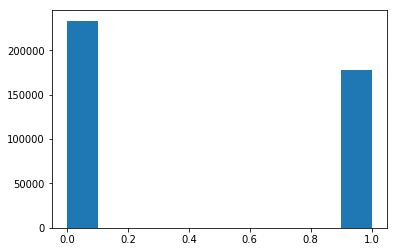

In [35]:
# Distribution of 'accepted' (whether an applicant was accepted to the school)
plt.hist(df_law['accepted'])

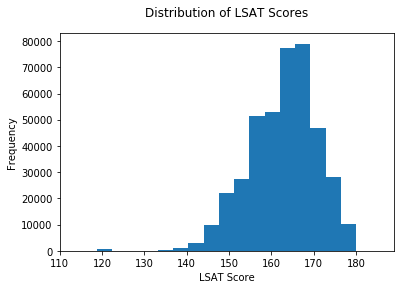

In [36]:
# Distribution of lsat scores
plt.hist(df_law['lsat'], bins=50)
plt.xlim(110,)
plt.title('Distribution of LSAT Scores', y=1.05)
plt.xlabel('LSAT Score')
plt.ylabel('Frequency')
plt.savefig('lsat-hist.jpg', dpi=150, bbox_inches = "tight")

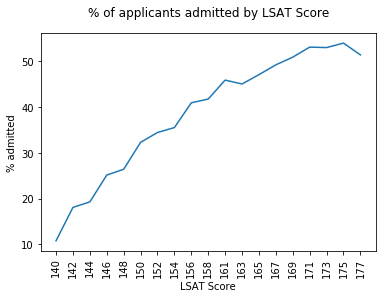

In [37]:
# % of applicants admitted by LSAT Score
df_lsat = df_law.loc[:, ['lsat', 'accepted']]
lsat_bins = np.linspace(140, 180, 20)
df_lsat['lsat_binned'] = pd.cut(df_lsat['lsat'], bins = lsat_bins)
lsat_group = df_lsat.groupby('lsat_binned').mean()

x_axis = range(len(lsat_bins)-1)
x_label = [int(x) for x in lsat_bins]
plt.plot(x_axis, lsat_group['accepted'] *100)

plt.xticks(x_axis, x_label, rotation=90)
plt.title('% of applicants admitted by LSAT Score', y=1.05)
plt.xlabel('LSAT Score')
plt.ylabel('% admitted')
plt.savefig('lsat-admissions.jpg', dpi=150, bbox_inches = "tight")

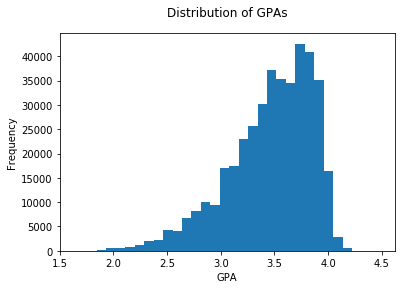

In [38]:
# Distribution of GPAs
plt.hist(df_law['gpa'], bins=50)
plt.xlim(1.5,)
plt.title('Distribution of GPAs', y=1.05)
plt.xlabel('GPA')
plt.ylabel('Frequency')
plt.savefig('gpa-hist.jpg', dpi=150, bbox_inches = "tight")

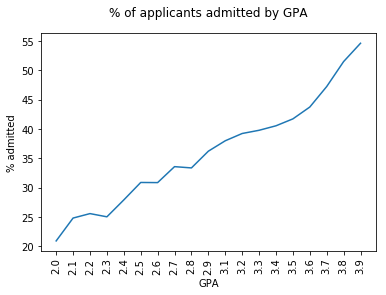

In [39]:
df_gpa = df_law.loc[:, ['gpa', 'accepted']]
gpa_bins = np.linspace(2, 4, 20)
df_gpa['gpa_binned'] = pd.cut(df_gpa['gpa'], bins = gpa_bins)
gpa_group = df_gpa.groupby('gpa_binned').mean()

x_axis = range(len(gpa_bins)-1)
x_label = [x.round(1) for x in gpa_bins]
plt.plot(x_axis, gpa_group['accepted'] *100)

plt.xticks(x_axis, x_label, rotation=90)
plt.title('% of applicants admitted by GPA', y=1.05)
plt.xlabel('GPA')
plt.ylabel('% admitted')
plt.savefig('gpa-admissions.jpg', dpi=150, bbox_inches = "tight")

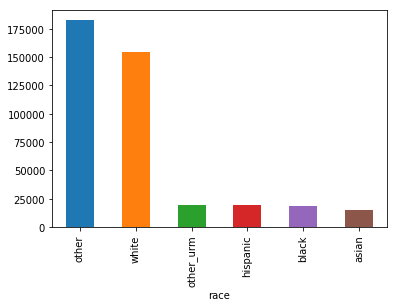

In [40]:
# Distribution of races
df_law.groupby('race')['race'].count().sort_values(ascending=False).plot.bar()

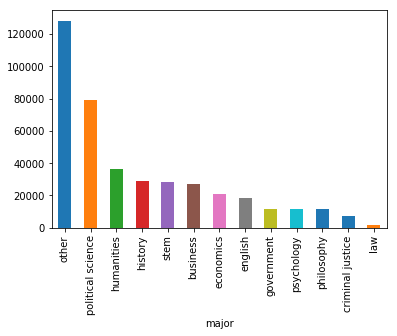

In [41]:
# Distribution of majors
df_law.groupby('major')['major'].count().sort_values(ascending=False).plot.bar()

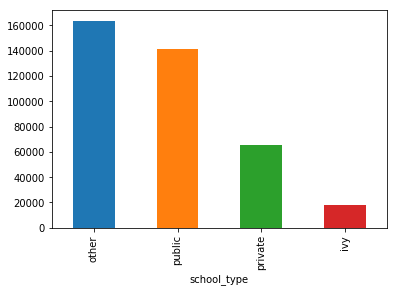

In [42]:
# Distribution of 'school_type' which the applicant attended for undergrad
df_law.groupby('school_type')['school_type'].count().sort_values(ascending=False).plot.bar()

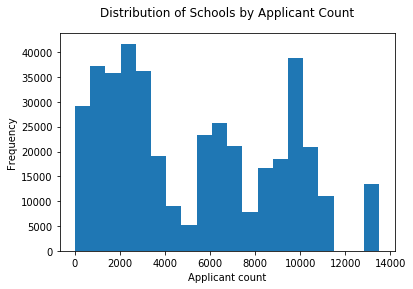

In [52]:
# Distribution of schools by applicant_count
group_school_count = df_law.groupby('school')['school'].count().sort_values(ascending=False)
dict_applicant_count = dict(group_school_count)
df_law['applicant_count'] = df_law['school'].map(dict_applicant_count)

plt.hist(df_law['applicant_count'], bins=20)
plt.title('Distribution of Schools by Applicant Count', y=1.05)
plt.xlabel('Applicant count')
plt.ylabel('Frequency')
plt.savefig('applicant-count.jpg', dpi=150, bbox_inches = "tight")

### Feature engineering

Select and create features to be used in the model to predict admissions outcomes. 

In [53]:
# Bucket schools by applicant_count
# 1 is for schools with over 8000 applicants, 2 is for schools with other 4000, and 3 is for other schools
df_law['applicant_count_level'] = df_law['applicant_count'].apply(lambda x: 1 if x>8000 else 2 if x>4000 else 3)

In [54]:
# Create 'in_state' column for applicants applying to a school that is in-state
df_law['in_state'] = np.where((df_law['applicant_state'] == df_law['school_state']), 1, 0)

In [55]:
# Create a weighted LSAT & GPA score (lsat_gpa_weighted) with each feature equally weighted on a 100-point scale
df_law['lsat_gpa_weighted'] = df_law.apply(lambda x: x['lsat']/180*50 + x['gpa']/4.4*50, axis=1)

In [56]:
# Select features from df_law and one hot encode categorical data (school, race)
df_law_features = pd.DataFrame(df_law[['gpa', 'lsat', 'lsat_gpa_weighted', 'in_state', 'applicant_count_level']])
df_race = pd.get_dummies(df_law['race'], prefix='race')
df_school = pd.get_dummies(df_law['school'], prefix='school')

In [57]:
# Create X with features that will be used to predict the target
X = pd.concat([df_law_features, df_race, df_school], axis=1)
X.head()

,gpa,lsat,lsat_gpa_weighted,in_state,applicant_count_level,race_asian,race_black,race_hispanic,race_other,race_other_urm,race_white,school_akron,school_alabama,school_albany,school_alberta,school_american,school_appalachian,school_arizona,school_arkansas,school_asu,school_avemaria,school_baltimore,school_barry,school_baylor,school_bc,school_belmont,school_berkeley,school_brittishcolumbia,school_brooklyn,school_bu,school_buffalo,school_byu,school_calgary,school_calwestern,school_campbell,school_capital,school_cardozo,school_casewestern,school_catholic,school_chapman,school_charleston,school_charlotte,school_chicago,school_chicago-kent,school_cincinnati,school_clevelandstate,school_colorado,school_columbia,school_cooley,school_cornell,school_creighton,school_cuny-queens,school_dalhousie,school_davis,school_dayton,school_denver,school_depaul,school_detroit-mercy,school_drake,school_drexel,school_duke,school_duquesne,school_elon,school_emory,school_famu,school_fiu,school_florida,school_floridacoastal,school_fordham,school_fsu,school_georgia,school_gmu,school_goldengate,school_gonzaga,school_gsu,school_gulc,school_gw,school_hamline,school_harvard,school_hastings,school_hawaii,school_hofstra,school_houston,school_howard,school_idaho,school_illinois,school_indiana,school_indiana-indy,school_interamerican,school_iowa,school_irvine,school_johnmarshal-atl,school_johnmarshal-chicago,school_jones,school_kansas,school_kentucky,school_laverne,school_lewisandclark,school_liberty,school_louisville,school_loyala-chicago,school_loyola,school_loyola-neworleans,school_lsu,school_maine,school_manitoba,school_marquette,school_maryland,school_massachusetts,school_mcgill,school_memphis,school_mercer,school_miami,school_michigan,school_minnesota,school_mississippi,school_mississippicollege,school_missouri,school_missouri-kc,school_montana,school_msu,school_nashville,school_nccu,school_nebraska,school_nevada,school_newbrunswick,school_newengland,school_newhampshire,school_newmexico,school_newyork,school_niu,school_nku,school_northdakota,school_northeastern,school_northwestern,school_notredame,school_nova,school_nyu,school_ocu,school_oklahoma,school_onu,school_oregon,school_osu,school_ottawa,school_pace,school_pacific,school_penn,school_pennstate,school_pepperdine,school_phoenix,school_pitt,school_pontifical,school_puertorico,school_queens,school_quinnipiac,school_regent,school_richmond,school_rogerwilliams,school_rutgers,school_samford,school_sandiego,school_sanfranciso,school_santaclara,school_saskatchewan,school_seattle,school_setonhall,school_siu,school_slu,school_smu,school_southcarolina,school_southdakota,school_southern,school_southtexas,school_southwestern,school_stanford,school_stetson,school_stjohns,school_stmarys,school_stthomas,school_stu,school_suffolk,school_syracuse,school_temple,school_tennessee,school_texas,school_texasam,school_texassouthern,school_texastech,school_thomasjefferson,school_toledo,school_toronto,school_touro,school_tulane,school_tulsa,school_ucla,school_uconn,school_udc,school_unc,school_usc,school_utah,school_uva,school_valparaiso,school_vanderbilt,school_vermont,school_victoria,school_villanova,school_wake,school_washburn,school_washington,school_washu,school_wayne,school_westernnewengland,school_westernontario,school_westernstate,school_whittier,school_widener,school_willamette,school_williammitchell,school_windsor,school_wisconsin,school_wl,school_wm,school_wvu,school_wyoming,school_yale,school_york
0,3.74,173,90.555556,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.74,173,90.555556,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

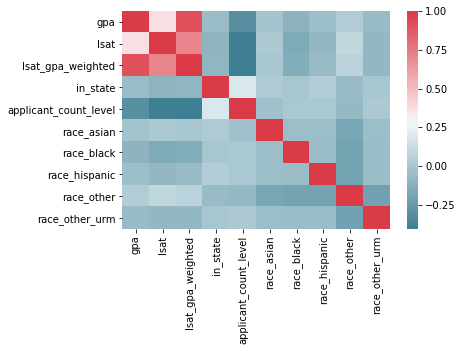

In [58]:
# Correlation matrix to show the correlation between features

corr = X[['gpa', 'lsat', 'lsat_gpa_weighted', 'in_state', 'applicant_count_level', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_other_urm']].corr()
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
sns.heatmap(corr, cmap=cmap)

### Test models

In [59]:
# Create y with the prediction target 'accepted' (whether an applicant was accepted by a school)
y = df_law['accepted']

In [60]:
# Split data into training and validation data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [61]:
# Define the function model_test to run all models and return the name of the model and its MAE

def model_test(models):
    list_model_mae = []
    
    for model_name, model_type in models.items():
        model = model_type.fit(train_X, train_y)
        prediction = model.predict(val_X)
        mae = mean_absolute_error(val_y, prediction)
        list_model_mae.append(tuple((model_name, mae)))
    
    return sorted(list_model_mae, key=itemgetter(1))

In [62]:
# Create dict_models with the models to be tested

dict_models = {
    'Random Forest': RandomForestClassifier(random_state=1),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=3),
    'Gaussian Naive Bayes': GaussianNB()
}

In [24]:
# Run model_test
model_test(dict_models)

[('Logistic Regression', 0.2560824822563843),
 ('Random Forest', 0.27460009930583273),
 ('KNN', 0.2770535375268953),
 ('Decision Tree', 0.2947338701040764),
 ('Gaussian Naive Bayes', 0.39733042555470094)]

model_test (above) shows that logistic regression and random forest are the most accurate models for our data.

In [25]:
# Check feature importance for the Random Forest model
forest = ExtraTreesClassifier(random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print(f"{f + 1}. {X.columns[indices[f]]} ({importances[indices[f]]})")

1. lsat_gpa_weighted (0.29669533338789)
2. lsat (0.25664937079274425)
3. gpa (0.21712584387273245)
4. applicant_count_level (0.02234175544498992)
5. school_stanford (0.008886860096007119)
6. school_yale (0.006307835950748718)
7. school_harvard (0.0041875311062217245)
8. race_white (0.0036695252210099992)
9. in_state (0.0036535301550632794)
10. race_other (0.0035809941206745967)
11. school_penn (0.002995845233650128)
12. school_berkeley (0.002879338418400899)
13. race_black (0.002809416098792088)
14. school_uva (0.002465089566862744)
15. school_gw (0.0023358220692482573)
16. school_columbia (0.002286183576744325)
17. race_hispanic (0.002240012449045281)
18. school_gulc (0.002125253586657087)
19. school_miami (0.0017831869194280948)
20. school_minnesota (0.0017373802346364003)
21. school_northwestern (0.0016754615892855633)
22. school_georgia (0.0016556987481065044)
23. school_cardozo (0.0016242867272569087)
24. school_sandiego (0.0016060263791860929)
25. race_asian (0.001596154286217023

### Fine-tune models by adjusting parameters

In [26]:
# Create a function to run logistic regression over a list of values for parameter C (inverse of regularization) optimize accuracy

def logit(c):
    dict_logit_mae = {}    
    
    for i in c:
        model = LogisticRegression(C=i).fit(train_X, train_y)
        prediction = model.predict(val_X)
        mae = mean_absolute_error(val_y, prediction)
        dict_logit_mae[i] = mae
    
    return dict_logit_mae

In [27]:
# Adjusting C appears to have little impact on accuracy
list_c = range(1, 100, 10)
logit(list_c)

{1: 0.2560824822563843,
 11: 0.25561516069046764,
 21: 0.25560542482451104,
 31: 0.25561516069046764,
 41: 0.25559568895855445,
 51: 0.2555762172266412,
 61: 0.2558196138755562,
 71: 0.2556735758862072,
 81: 0.25575146281385996,
 91: 0.2555762172266412}

In [63]:
# Create a function to run Random Forest over a list of values for n_estimators (number of trees) to optimize accuracy

def forest_est(n):
    dict_forest_mae = {}    
    
    for i in n:
        model = RandomForestClassifier(random_state=1, n_estimators=i).fit(train_X, train_y)
        prediction = model.predict(val_X)
        mae = mean_absolute_error(val_y, prediction)
        dict_forest_mae[i] = mae
    
    return dict_forest_mae

In [64]:
# n_estimators as 100 appears to be a good value for our model.
# Values over 100 marginally reduce error but take much longer to run. 
list_n = range(10, 200, 20)
forest_est(list_n)

{10: 0.27460009930583273,
 30: 0.2668795576022509,
 50: 0.26478634642158244,
 70: 0.2644066476492752,
 90: 0.26337464585787584,
 110: 0.26282943736430636,
 130: 0.26255683311752165,
 150: 0.26254709725156505,
 170: 0.26205056808777855,
 190: 0.2620797756856484}

In [65]:
# Create a function to run Random Forest over a list of values for max_features to optimize accuracy

def forest_features(n):
    dict_forest_mae = {}
    
    for i in n:
        model = RandomForestClassifier(random_state=1, max_features=i).fit(train_X, train_y)
        prediction = model.predict(val_X)
        mae = mean_absolute_error(val_y, prediction)
        dict_forest_mae[i] = mae
    
    return dict_forest_mae

In [66]:
# max_features as 50 appears to be a good value for our model

list_max_features = range(10, 80, 10)
forest_features(list_max_features)

{10: 0.27423013639948207,
 20: 0.2727016054442962,
 30: 0.2699950347083621,
 40: 0.26962507180201145,
 50: 0.2693232599573569,
 60: 0.26907986330844197,
 70: 0.2682425788361746}

In [114]:
# Random Forest for optimized n_estimators and max_features

model = RandomForestClassifier(random_state=1, max_features=50, n_estimators=100).fit(train_X, train_y)
prediction = model.predict(val_X)
mae = mean_absolute_error(val_y, prediction)
mae

0.26094067936872645